In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = '/content/drive/MyDrive/attn.pth'
    lstm_state_path = '/content/drive/MyDrive/lstm.pth'
    cnn_state_path = '/content/drive/MyDrive/cnn.pth'

    attn_logs = '/content/drive/MyDrive/attn.csv'
    lstm_logs = '/content/drive/MyDrive/lstm.csv'
    cnn_logs = '/content/drive/MyDrive/cnn.csv'

    train_csv_path = '/content/drive/MyDrive/mitbih_with_syntetic_train.csv'
    test_csv_path = '/content/drive/MyDrive/mitbih_with_syntetic_test.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [ ]:
df_ptbdb = pd.read_csv('/content/drive/MyDrive/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv')
df_ptbdb

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10501,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_mitbih_train = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/content/drive/MyDrive/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

In [ ]:
df_mitbih = pd.read_csv(config.csv_path)
df_mitbih['label'].value_counts()

,count
label,
Normal,90589
Fusion of paced and normal,8039
Premature ventricular contraction,7236
Artial Premature,2779
Fusion of ventricular and normal,803


In [ ]:
config.csv_path = '/content/drive/MyDrive/mitbih_with_syntetic.csv'
df_mitbih_new = pd.read_csv(config.csv_path)


In [ ]:
%%time
signals = [' '.join(df_mitbih.iloc[i, :-1].apply(str).values) for i in range(df_mitbih.shape[0])]
y = df_mitbih.iloc[:, -1].values.tolist()
print(len(signals), len(y))

print(f'data has {len(set([sig for line in signals for sig in line.split()]))} out of 16 372 411 unique values.')

109446 109446
data has 279149 out of 16 372 411 unique values.
CPU times: user 1min 2s, sys: 2.62 s, total: 1min 5s
Wall time: 1min 6s


In [ ]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [ ]:
def get_dataloader(phase: str, batch_size: int =32 ) -> DataLoader:
    '''
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=2)
    return dataloader

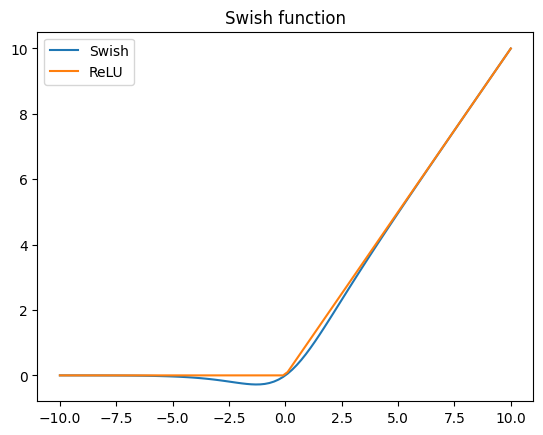

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()


In [ ]:


class ConvNormPool(nn.Module):
    """Xây dựng các cấu trúc hàm"""
    def __init__(self, input_size, hidden_size, kernel_size, norm_type='batchnorm'):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )

        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()

        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(num_groups=8, num_channels=hidden_size)
            self.normalization_2 = nn.GroupNorm(num_groups=8, num_channels=hidden_size)
            self.normalization_3 = nn.GroupNorm(num_groups=8, num_channels=hidden_size)
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)


    """Thực hiện thuật toán"""
    def forward(self, input):
        # Step 1
        x = self.conv_1(input)
        x = self.normalization_1(x)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        # Step 2
        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        # Step 3 - Residual skip
        residual = x
        x = self.conv_3(x)

        # Ensure same length before addition
        if x.shape[-1] != residual.shape[-1]:
            diff = residual.shape[-1] - x.shape[-1]
            residual = residual[..., diff:]

        x = self.normalization_3(x + residual)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [ ]:
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_size=1, hid_size=256, rnn_size=64, kernel_size=5, num_classes=5):
        super().__init__()
        self.conv1 = ConvNormPool(input_size, hid_size, kernel_size)
        self.conv2 = ConvNormPool(hid_size, hid_size // 2, kernel_size)
        self.conv3 = ConvNormPool(hid_size // 2, hid_size // 4, kernel_size)

        self.bilstm = nn.LSTM(
            input_size=hid_size // 4,  # input size for LSTM
            hidden_size=rnn_size,      # hidden size of LSTM
            batch_first=True,
            bidirectional=True
        )

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(2 * rnn_size, num_classes)  # 2 * rnn_size due to bidirectional

    def forward(self, input):
        # input shape: (B, C=1, T)
        x = self.conv1(input)  # shape: (B, hid, T1)
        x = self.conv2(x)      # shape: (B, hid//2, T2)
        x = self.conv3(x)      # shape: (B, hid//4, T3)

        x = x.permute(0, 2, 1)  # to (B, T, C) for LSTM
        lstm_out, _ = self.bilstm(x)  # (B, T, 2*rnn_size)

        lstm_out = lstm_out.permute(0, 2, 1)  # (B, 2*rnn_size, T)
        x = self.avgpool(lstm_out)  # (B, 2*rnn_size, 1)
        x = x.view(x.size(0), -1)   # (B, 2*rnn_size)

        x = self.fc(x)              # (B, num_classes)
        return x


In [ ]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion

In [ ]:
from tqdm import tqdm

class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"\n🟦 {phase.upper()} START | Time: {time.strftime('%H:%M:%S')}")
        self.net.train() if phase == 'train' else self.net.eval()

        meter = Meter()
        meter.init_metrics()
        total_loss = 0
        total_batches = len(self.dataloaders[phase])
        start_time = time.time()

        pbar = tqdm(enumerate(self.dataloaders[phase]), total=total_batches, desc=f"{phase.upper()}", ncols=100)

        for i, (data, target) in pbar:
            data = data.to(config.device)
            target = target.to(config.device).long()

            try:
                output = self.net(data)
                loss = self.criterion(output, target)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                if phase == 'train':
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                meter.update(output, target, loss.item())
                total_loss += loss.item()
                avg_loss_so_far = total_loss / (i + 1)
                pbar.set_postfix(loss=loss.item(), avg=avg_loss_so_far)

            except Exception as e:
                print(f"\n❌ Error in batch {i+1}: {e}")
                continue

        elapsed = time.time() - start_time
        avg_step_ms = (elapsed / total_batches) * 1000 if total_batches > 0 else 0

        metrics = meter.get_metrics()
        metrics = {k: v / total_batches for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        print(f"{total_batches}/{total_batches} [==============================] - {int(elapsed)}s {int(avg_step_ms)}ms/step - loss: {metrics['loss']:.4e}")

        return metrics['loss']

    def run(self):
        for epoch in range(self.num_epochs):
            print(f"\n📘 Epoch {epoch + 1}/{self.num_epochs}")

            train_loss = self._train_epoch(phase='train')

            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            print(f"📊 Epoch {epoch + 1} Summary - loss: {train_loss:.4e} - val_loss: {val_loss:.4e}")

            if val_loss < self.best_loss:
                print(f"✅ New best val_loss: {val_loss:.4f} < {self.best_loss:.4f}")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoch{epoch + 1}.pth")
            else:
                print(f"ℹ️ No improvement in val_loss: {val_loss:.4f} >= {self.best_loss:.4f}")



In [ ]:
y_true_all, y_pred_all = [], []

model.eval()
with torch.no_grad():
    for data, target in trainer.dataloaders['val']:
        data = data.to(config.device)
        target = target.to(config.device).long()

        output = model(data)
        _, preds = torch.max(output, 1)

        y_true_all.extend(target.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

# 🟩 Bước 2: Tạo classification report dạng pandas DataFrame
target_names = [id_to_label[i] for i in sorted(id_to_label.keys())]
report = classification_report(
    y_true_all, y_pred_all,
    target_names=target_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()


<ipython-input-17-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-17-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


NameError: name 'report' is not defined

In [ ]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)

            output = self.net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()


train mode | time: 18:24:24


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.21689871701456667, accuracy: 0.937852878953255, f1: 0.7731832515284921, precision: 0.8066574193843283, recall: 0.9118561748757258


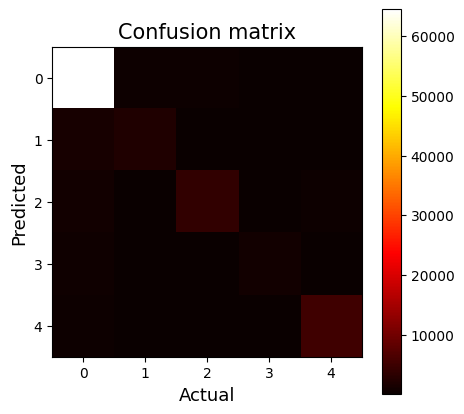

val mode | time: 18:59:04


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.13856539579765031, accuracy: 0.9621674057649667, f1: 0.8619046875705247, precision: 0.8667258769521253, recall: 0.9558405116199439


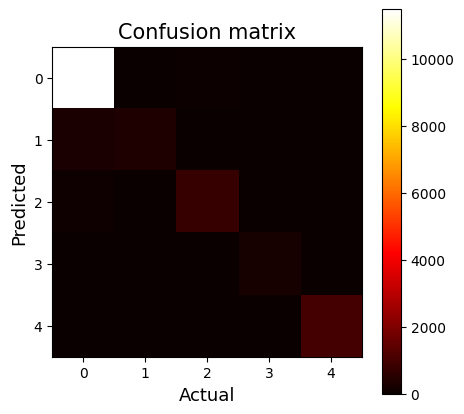


New checkpoint

train mode | time: 19:00:58


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.10529616764783364, accuracy: 0.971007919984908, f1: 0.898517411295656, precision: 0.9127004523212018, recall: 0.9549544225701831


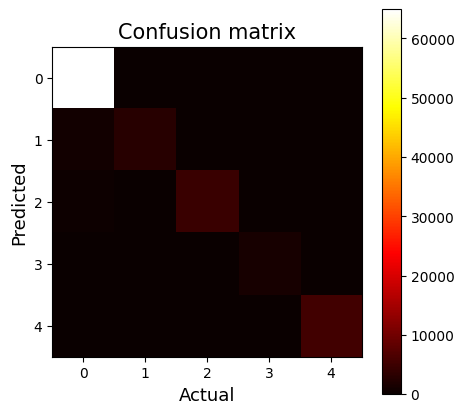

val mode | time: 19:35:28


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.12468507429667461, accuracy: 0.9633453436807096, f1: 0.8751527682743004, precision: 0.8974225606045473, recall: 0.9408152237337616


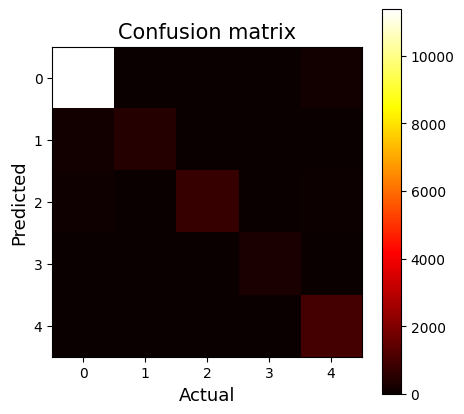

train mode | time: 19:37:22


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.07214529557746259, accuracy: 0.9801545592971393, f1: 0.9298010908804739, precision: 0.9385533607605815, recall: 0.9698486207178675


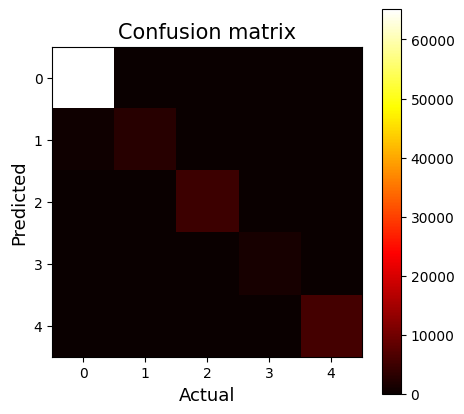

val mode | time: 20:11:46


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.06846436578832038, accuracy: 0.9824695121951219, f1: 0.9313619185623175, precision: 0.9327174578051307, recall: 0.9803949625388311


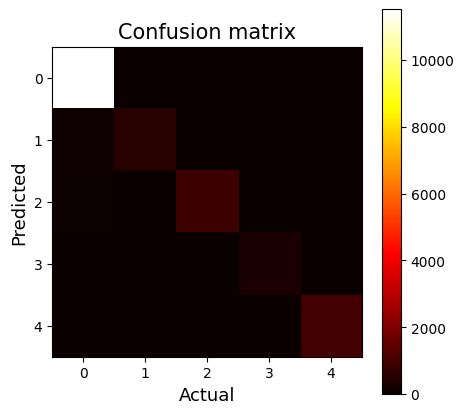


New checkpoint

train mode | time: 20:13:39


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.05159675925916397, accuracy: 0.9853580500195389, f1: 0.9457996206733729, precision: 0.9527169126340496, recall: 0.9774354902667854


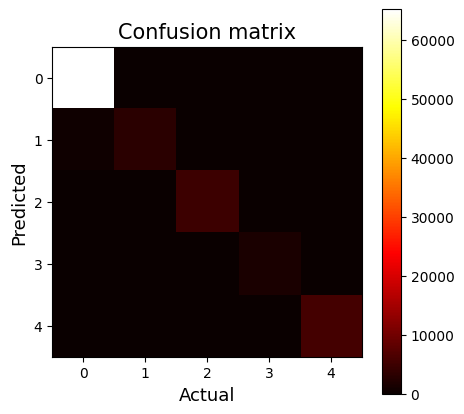

val mode | time: 20:47:54


<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


loss: 0.05222088044293497, accuracy: 0.9864883592017738, f1: 0.9489643308259279, precision: 0.9574491509449368, recall: 0.975235601591068


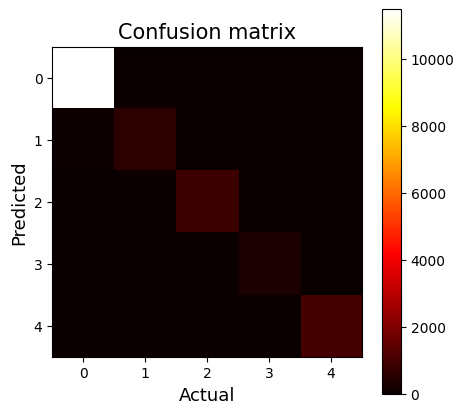


New checkpoint



In [ ]:
model = CNN_BiLSTM(input_size=1, hid_size=256, kernel_size=5, num_classes=5)
trainer = Trainer(net=model, lr=1e-3, batch_size=32, num_epochs=4)#100)
trainer.run()

<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


                                   precision    recall  f1-score       support
Normal                              0.988894  0.994373  0.991626  11551.000000
Artial Premature                    0.952703  0.854545  0.900958    660.000000
Premature ventricular contraction   0.948936  0.966414  0.957595    923.000000
Fusion of ventricular and normal    0.985560  0.916107  0.949565    298.000000
Fusion of paced and normal          0.982575  0.990244  0.986395   1025.000000
accuracy                            0.984298  0.984298  0.984298      0.984298
macro avg                           0.971733  0.944337  0.957228  14457.000000
weighted avg                        0.984174  0.984298  0.984076  14457.000000


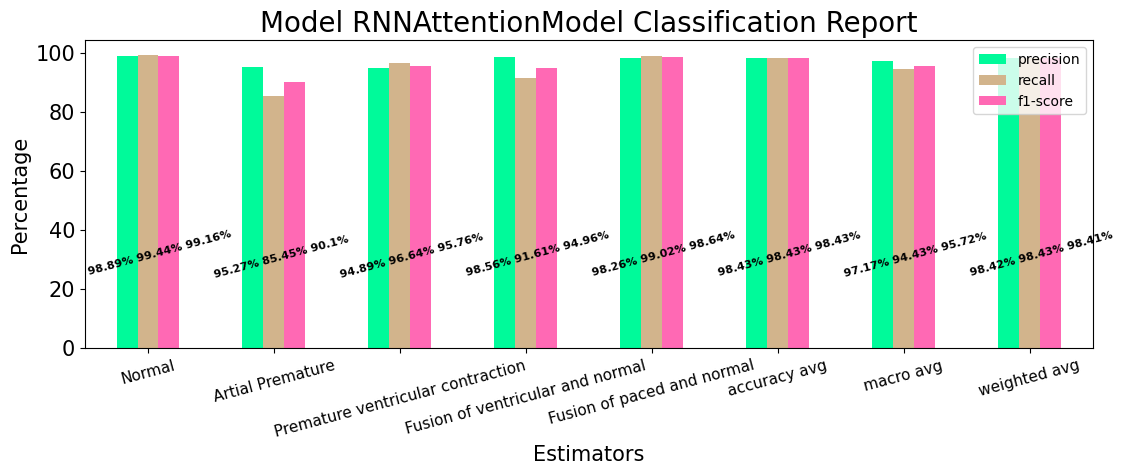

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuyển mô hình sang device (GPU hoặc CPU)
model.to(device)

# Tạo DataLoader cho validation
val_loader = get_dataloader(phase='val', batch_size=32)  # Gọi hàm get_dataloader cho validation

# Đặt mô hình về chế độ đánh giá
model.eval()  # Chuyển mô hình sang chế độ đánh giá (evaluation mode)

y_true = []  # Nhãn thực tế
y_pred = []  # Nhãn dự đoán

# Dự đoán trên tập kiểm tra
with torch.no_grad():  # Tắt tính toán gradient (vì không cần backpropagation)
    for inputs, labels in val_loader:
        # Đảm bảo inputs và labels là tensor và chuyển sang device (GPU hoặc CPU)
        inputs = inputs.to(device)  # Chuyển inputs sang device
        labels = labels.to(device)  # Chuyển labels sang device

        outputs = model(inputs)  # Mô hình đưa ra dự đoán
        _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp có xác suất cao nhất

        y_true.extend(labels.cpu().numpy())  # Thêm nhãn thực tế vào y_true
        y_pred.extend(predicted.cpu().numpy())  # Thêm nhãn dự đoán vào y_pred

# Tính toán báo cáo phân loại
report = classification_report(y_true, y_pred, target_names=list(id_to_label.values()), output_dict=True)

# Chuyển đổi báo cáo thành DataFrame để dễ dàng vẽ
report_df = pd.DataFrame(report).transpose()

# Hiển thị báo cáo phân loại
print(report_df)

# Vẽ biểu đồ nếu cần
import matplotlib.pyplot as plt

colors = ['#00FA9A', '#D2B48C', '#FF69B4']  # Màu sắc cho biểu đồ
report_plot = report_df.apply(lambda x: x * 100)  # Chuyển báo cáo thành phần trăm
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar', figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values()) + ["accuracy avg", "macro avg", "weighted avg"],
    rotation=15, fontsize=11
)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("Model RNNAttentionModel Classification Report", fontsize=20)

# Annotate tỷ lệ trên mỗi cột của biểu đồ
for percentage, p in zip(
    report_df[['precision', 'recall', 'f1-score']].values,
    ax.patches
):
    percentage = " ".join([str(round(i * 100, 2)) + "%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')

# Lưu biểu đồ dưới dạng ảnh PNG và SVG
fig = plt.gcf()
fig.savefig("model_report.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("model_report.svg", format="svg", pad_inches=0.2, transparent=False, bbox_inches='tight')

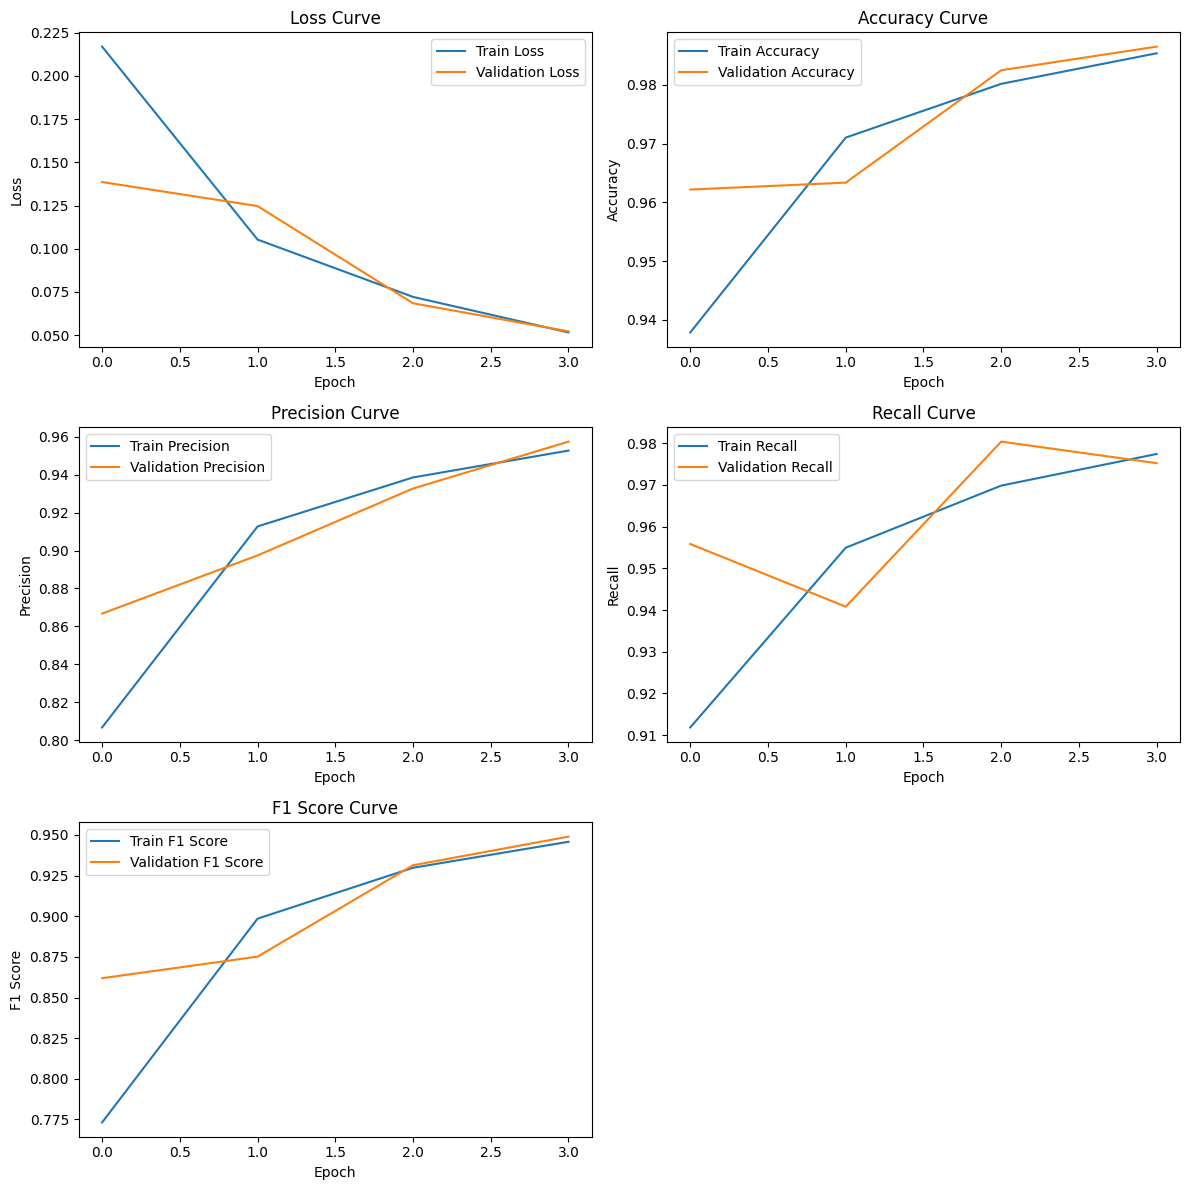

In [ ]:
import matplotlib.pyplot as plt

# Sau khi huấn luyện xong, bạn có thể gọi hàm vẽ biểu đồ
def plot_training_progress(trainer):
    # Lấy các giá trị từ DataFrame
    train_losses = trainer.train_df_logs['loss'].values
    val_losses = trainer.val_df_logs['loss'].values
    train_accuracies = trainer.train_df_logs['accuracy'].values
    val_accuracies = trainer.val_df_logs['accuracy'].values
    train_precisions = trainer.train_df_logs['precision'].values
    val_precisions = trainer.val_df_logs['precision'].values
    train_recalls = trainer.train_df_logs['recall'].values
    val_recalls = trainer.val_df_logs['recall'].values
    train_f1_scores = trainer.train_df_logs['f1'].values
    val_f1_scores = trainer.val_df_logs['f1'].values

    # Tạo figure và các subplots
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.ravel()  # Lấy array của axes

    # Loss Curve
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Loss Curve')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy Curve
    axes[1].plot(train_accuracies, label='Train Accuracy')
    axes[1].plot(val_accuracies, label='Validation Accuracy')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Precision Curve
    axes[2].plot(train_precisions, label='Train Precision')
    axes[2].plot(val_precisions, label='Validation Precision')
    axes[2].set_title('Precision Curve')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Precision')
    axes[2].legend()

    # Recall Curve
    axes[3].plot(train_recalls, label='Train Recall')
    axes[3].plot(val_recalls, label='Validation Recall')
    axes[3].set_title('Recall Curve')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Recall')
    axes[3].legend()

    # F1 Score Curve
    axes[4].plot(train_f1_scores, label='Train F1 Score')
    axes[4].plot(val_f1_scores, label='Validation F1 Score')
    axes[4].set_title('F1 Score Curve')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('F1 Score')
    axes[4].legend()

    # Tắt subplot thứ 6 vì chúng ta chỉ vẽ 5 biểu đồ
    fig.delaxes(axes[5])

    # Tối ưu layout để không bị chồng lấn
    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ các biểu đồ
plot_training_progress(trainer)